**MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE**.

**Course: TC5035.10 - Integration project**

Tecnológico de Monterrey

Professor Dr. Horacio Martínez Alfaro

**Week 2, Activity 1**

Exploratory data analysis

---

*   Student: Jorge Antonio Acosta Rosales
*   Registration: A01381552
*   Student: Israel Luján González
*   Registration: A01794693

## **Part 0.** Problem Context and Team Objective

Despite being taught by several institutions and supported by the government, Mexican Sign Language (LSM) still lacks sufficient digitalization. This limits the development of accessibility tools for people with hearing or speech impairments, as well as resources that could help bridge the communication gap between them and individuals without such disabilities who wish to communicate with them.

The goal of our machine learning project is to build a solid, well-structured dataset and develop automatic classification methods that simplify the labeling process. This dataset is intended to serve as a foundational resource for future projects—whether supervised or unsupervised—that aim to create real-time sign language translation tools.

Our project focuses on creating a universal web platform for data capture, using machine learning models to detect hand landmarks and employing our own ML classifier to recognize specific gestures. Due to time constraints, the current version of the project concentrates on static gestures only. However, work is ongoing to develop solutions for dynamic gestures that future teams can continue to build upon.

Finally, we also propose the use of generative AI models to perform style transfer, enhance registered images, and generate synthetic data under varied lighting conditions. This will further enrich the dataset and improve the performance of our classification model.

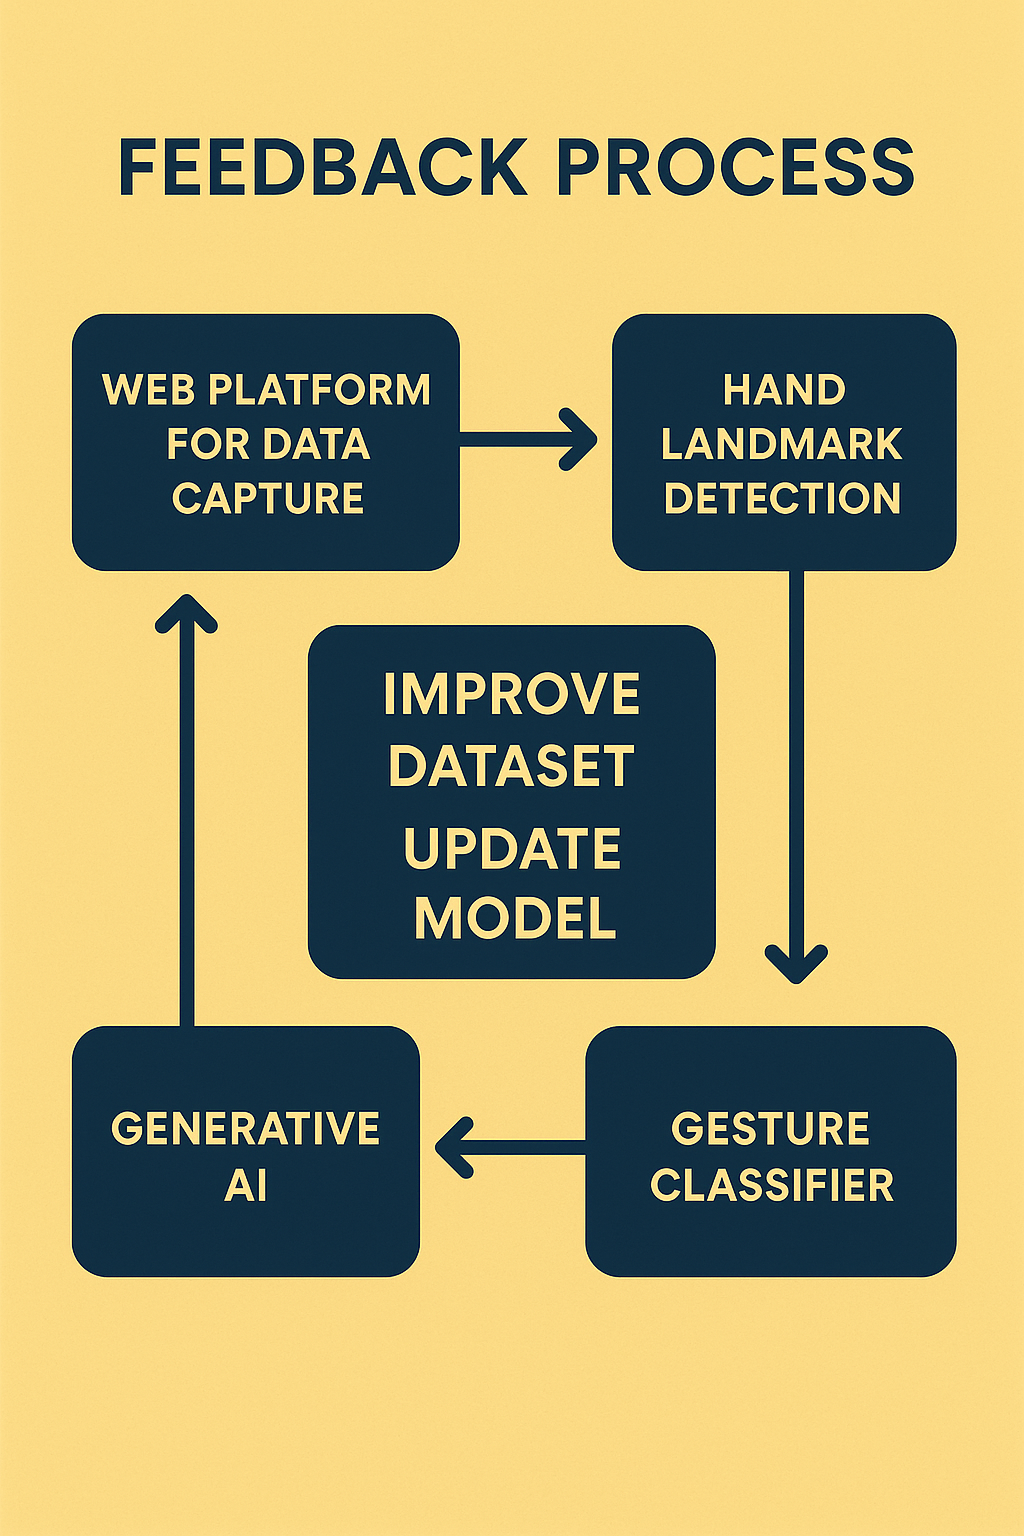

# **Part 1**. EDA and preprocessing

### Obtaining descriptive statistics for all the variables in the dataframe. 

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [114]:
# Load variables from .env file for local development or get it from the environment variables in production
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass  # Safe fallback if it's not available in prod

base_path = os.getenv("LSM_BASE")
if not base_path:
    raise ValueError("❌ Environment variable 'LSM_BASE' is not set!")

model_path = os.path.join(base_path, "models", "hand_landmarker.task")
gestures_json_path = os.path.join(base_path, "data", "metadata", "gestures.json")

In [115]:
# Load JSON files
gestures_df = pd.read_json(gestures_json_path)


print("Summary of the datatypes and the values in the gestures dataset:")
display(gestures_df.head())
print("-" * 50)
gestures_df.info()
print("-" * 50)
gestures_df.dtypes

Summary of the datatypes and the values in the gestures dataset:


,id,image,video,letter,gesture_type,timestamp,source_file,image_size,hand_count,handedness_detected,hand_confidence,landmarks,fps,total_frames
0,A_img_a5925fe9,A_img_a5925fe9.jpg,None,A,static,2025-05-05 06:23:18.325563+00:00,data\raw\A\a10_png.rf.034598b5a2298fcf3f48a42e...,"[640, 480]",1,[right],"{'right_hand': 0.993110239505767, 'left_hand':...","{'right_hand': [{'x': 0.6441410779953001, 'y':...",NaN,NaN
1,A_img_ec30f61d,A_img_ec30f61d.jpg,None,A,static,2025-05-05 06:23:18.366548+00:00,data\raw\A\a10_png.rf.98df28d9e488f67003dd2a4e...,"[640, 480]",1,[right],"{'right_hand': 0.993110239505767, 'left_hand':...","{'right_hand': [{'x': 0.6441410779953001, 'y':...",NaN,NaN
2,A_img_a83525ad,A_img_a83525ad.jpg,None,A,static,2025-05-05 06:23:18.412633+00:00,data\raw\A\a10_png.rf.d6815149e774ac7b45aa29d1...,"[640, 480]",1,[right],"{'right_hand': 0.990341246128082, 'left_hand':...","{'right_hand': [{'x': 0.25305351614952004, 'y'...",NaN,NaN
3,A_img_eee4ef32,A_img_eee4ef32.jpg,None,A,static,2025-05-05 06:23:18.453359+00:00,data\raw\A\a11_png.rf.4c2e36a88f5c2cbd29b88d33...,"[640, 480]",1,[left],"{'right_hand': None, 'left_hand': 0.9960017800...","{'right_hand': None, 'left_hand': [{'x': 0.717...",NaN,NaN
4,A_img_e65e5f33,A_img_e65e5f33.jpg,None,A,static,2025-05-05 06:23:18.493991+00:00,data\raw\A\a11_png.rf.9e17f5b8cd8398859d531bbb...,"[640, 480]",1,[left],"{'right_hand': None, 'left_hand': 0.9958202838...","{'right_hand': None, 'left_hand': [{'x': 0.439...",NaN,NaN


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   id                   1724 non-null   object             
 1   image                1716 non-null   object             
 2   video                8 non-null      object             
 3   letter               1724 non-null   object             
 4   gesture_type         1724 non-null   object             
 5   timestamp            1724 non-null   datetime64[ns, UTC]
 6   source_file          1724 non-null   object             
 7   image_size           1724 non-null   object             
 8   hand_count           1724 non-null   int64              
 9   handedness_detected  1716 non-null   object             
 10  hand_confidence      1716 non-null   object             
 11  landmarks            1724 non-n

id                                  object
image                               object
video                               object
letter                              object
gesture_type                        object
timestamp              datetime64[ns, UTC]
source_file                         object
image_size                          object
hand_count                           int64
handedness_detected                 object
hand_confidence                     object
landmarks                           object
fps                                float64
total_frames                       float64
dtype: object

# Data Transformation 
The data has nested structures, especially in 'landmarks'. Let's flatten it for easier analysis. We'll extract key information like the number of landmarks detected per frame and maybe average positions, but for a full EDA, dealing with the sequence data might require more complex approaches. For now, let's extract non-landmark features and basic landmark info.

In [116]:
if 'timestamp' in gestures_df.columns:
    gestures_df['timestamp'] = pd.to_datetime(gestures_df['timestamp'])
else:
    print("Warning: 'timestamp' column not found.")

# Handle potential list in 'handedness_detected' -> convert to string
if 'handedness_detected' in gestures_df.columns:
     # Check the type of the first non-null entry to decide how to handle
    first_handedness = gestures_df['handedness_detected'].dropna().iloc[0] if not gestures_df['handedness_detected'].isnull().all() else None

    if isinstance(first_handedness, list):
        print("Converting 'handedness_detected' list to sorted string.")
        # Apply transformation: sort list elements and join
        gestures_df['handedness_detected'] = gestures_df['handedness_detected'].apply(
            lambda x: ', '.join(sorted(x)) if isinstance(x, list) and x else None # Sort for consistency
        )
    elif isinstance(first_handedness, str):
         print("'handedness_detected' is already string type.")
    else:
         print("Handling 'handedness_detected' - unexpected type or all null.")
         # If it's neither list nor string (and not all null), might need inspection
         # For now, attempt conversion to string or leave as is if conversion fails
         gestures_df['handedness_detected'] = gestures_df['handedness_detected'].astype(str)


# Extract Hand Confidence (handle potential nested dict)
if 'hand_confidence' in gestures_df.columns and isinstance(gestures_df['hand_confidence'].iloc[0], dict):
    print("Extracting right/left hand confidence.")
    gestures_df['right_hand_confidence'] = gestures_df['hand_confidence'].apply(lambda x: x.get('right_hand') if isinstance(x, dict) else None)
    gestures_df['left_hand_confidence'] = gestures_df['hand_confidence'].apply(lambda x: x.get('left_hand') if isinstance(x, dict) else None)
    gestures_df.drop(columns=['hand_confidence'], inplace=True) # Drop original nested column
else:
    print("Warning: 'hand_confidence' column not found or not in expected dictionary format.")
    # Create columns even if source is missing, initialize with NaN
    if 'right_hand_confidence' not in gestures_df.columns:
      gestures_df['right_hand_confidence'] = np.nan
    if 'left_hand_confidence' not in gestures_df.columns:
      gestures_df['left_hand_confidence'] = np.nan


# Extract Image Width/Height (handle potential list)
if 'image_size' in gestures_df.columns and isinstance(gestures_df['image_size'].iloc[0], list):
     print("Extracting image width/height.")
     gestures_df['image_width'] = gestures_df['image_size'].apply(lambda x: x[0] if isinstance(x, list) and len(x)==2 else None)
     gestures_df['image_height'] = gestures_df['image_size'].apply(lambda x: x[1] if isinstance(x, list) and len(x)==2 else None)
     gestures_df.drop(columns=['image_size'], inplace=True) # Drop original nested column
else:
    print("Warning: 'image_size' column not found or not in expected list format.")
    # Create columns even if source is missing, initialize with NaN
    if 'image_width' not in gestures_df.columns:
      gestures_df['image_width'] = np.nan
    if 'image_height' not in gestures_df.columns:
      gestures_df['image_height'] = np.nan

Converting 'handedness_detected' list to sorted string.
Extracting right/left hand confidence.
Extracting image width/height.


In [117]:
# --- Landmark Processing (Revised for new structure) ---
print("Processing landmarks...")

# Helper function to extract landmark stats
def get_landmark_stats(landmarks_dict, hand):
    num_landmarks = 0
    avg_x, avg_y, avg_z = np.nan, np.nan, np.nan
    present = False
    if isinstance(landmarks_dict, dict) and hand in landmarks_dict:
        landmarks = landmarks_dict[hand]
        # Check if landmarks is a non-empty list
        if isinstance(landmarks, list) and landmarks:
            valid_landmarks = [lmk for lmk in landmarks if isinstance(lmk, dict) and all(k in lmk for k in ['x', 'y', 'z'])]
            num_landmarks = len(valid_landmarks)
            if num_landmarks > 0:
                present = True
                avg_x = np.mean([lmk['x'] for lmk in valid_landmarks])
                avg_y = np.mean([lmk['y'] for lmk in valid_landmarks])
                avg_z = np.mean([lmk['z'] for lmk in valid_landmarks])
    return present, num_landmarks, avg_x, avg_y, avg_z

# Apply the function for both hands if 'landmarks' column exists
if 'landmarks' in gestures_df.columns:
    # Right Hand
    results_rh = gestures_df['landmarks'].apply(lambda x: get_landmark_stats(x, 'right_hand'))
    gestures_df['rh_present'] = results_rh.apply(lambda x: x[0])
    gestures_df['num_rh_landmarks'] = results_rh.apply(lambda x: x[1]).astype(pd.Int64Dtype()) # Use nullable integer
    gestures_df['avg_rh_x'] = results_rh.apply(lambda x: x[2])
    gestures_df['avg_rh_y'] = results_rh.apply(lambda x: x[3])
    gestures_df['avg_rh_z'] = results_rh.apply(lambda x: x[4])

    # Left Hand
    results_lh = gestures_df['landmarks'].apply(lambda x: get_landmark_stats(x, 'left_hand'))
    gestures_df['lh_present'] = results_lh.apply(lambda x: x[0])
    gestures_df['num_lh_landmarks'] = results_lh.apply(lambda x: x[1]).astype(pd.Int64Dtype()) # Use nullable integer
    gestures_df['avg_lh_x'] = results_lh.apply(lambda x: x[2])
    gestures_df['avg_lh_y'] = results_lh.apply(lambda x: x[3])
    gestures_df['avg_lh_z'] = results_lh.apply(lambda x: x[4])

    # Drop original landmarks column if processed
    gestures_df.drop(columns=['landmarks'], inplace=True)
else:
    print("Warning: 'landmarks' column not found. Cannot extract landmark features.")
    # Create columns even if source is missing, initialize with appropriate defaults
    gestures_df['rh_present'] = False
    gestures_df['num_rh_landmarks'] = 0
    gestures_df['avg_rh_x'] = np.nan
    gestures_df['avg_rh_y'] = np.nan
    gestures_df['avg_rh_z'] = np.nan
    gestures_df['lh_present'] = False
    gestures_df['num_lh_landmarks'] = 0
    gestures_df['avg_lh_x'] = np.nan
    gestures_df['avg_lh_y'] = np.nan
    gestures_df['avg_lh_z'] = np.nan

Processing landmarks...


In [118]:
# --- Display Initial Info ---
print("\n--- Processed DataFrame Info ---")
gestures_df.info()

print("\n--- First 5 Rows ---")
# Increase display width for markdown
with pd.option_context('display.max_colwidth', None):
    print(gestures_df.head().to_markdown(index=False, numalign="left", stralign="left"))


--- Processed DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1724 entries, 0 to 1723
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   id                     1724 non-null   object             
 1   image                  1716 non-null   object             
 2   video                  8 non-null      object             
 3   letter                 1724 non-null   object             
 4   gesture_type           1724 non-null   object             
 5   timestamp              1724 non-null   datetime64[ns, UTC]
 6   source_file            1724 non-null   object             
 7   hand_count             1724 non-null   int64              
 8   handedness_detected    1716 non-null   object             
 9   fps                    8 non-null      float64            
 10  total_frames           8 non-null      float64            
 11  right_hand_confidence 

In [119]:
numerical_columns = gestures_df.select_dtypes(include = ['int', 'float']).columns
temporal_columns = gestures_df.select_dtypes(include = ['datetime64[ns, UTC]']).columns
categorical_columns = gestures_df.select_dtypes(include = ['object','category']).columns

print("Numerical columns: ", numerical_columns.to_list())
print("Temporal columns: ", temporal_columns.to_list())
print("Categorical columns: ", categorical_columns.to_list())
print(f"Number of numerical columns: {len(numerical_columns)}")
print(f"Number of temporal columns: {len(temporal_columns)}")
print(f"Number of categorical columns: {len(categorical_columns)}")  

Numerical columns:  ['hand_count', 'fps', 'total_frames', 'right_hand_confidence', 'left_hand_confidence', 'image_width', 'image_height', 'num_rh_landmarks', 'avg_rh_x', 'avg_rh_y', 'avg_rh_z', 'num_lh_landmarks', 'avg_lh_x', 'avg_lh_y', 'avg_lh_z']
Temporal columns:  ['timestamp']
Categorical columns:  ['id', 'image', 'video', 'letter', 'gesture_type', 'source_file', 'handedness_detected']
Number of numerical columns: 15
Number of temporal columns: 1
Number of categorical columns: 7


In [120]:
# Show the statistics of the numerical columns
gestures_df[numerical_columns].describe()

,hand_count,fps,total_frames,right_hand_confidence,left_hand_confidence,image_width,image_height,num_rh_landmarks,avg_rh_x,avg_rh_y,avg_rh_z,num_lh_landmarks,avg_lh_x,avg_lh_y,avg_lh_z
count,1724.000000,8.0,8.0,760.000000,1002.000000,1724.0,1724.0,1724.0,760.000000,760.000000,760.000000,1724.0,1002.000000,1002.000000,1002.000000
mean,1.324826,20.0,100.0,0.975853,0.976574,640.0,480.0,9.257541,0.557792,0.536248,-0.071531,12.205336,0.444604,0.498630,-0.069137
std,4.759089,0.0,0.0,0.051854,0.052489,0.0,0.0,10.429256,0.106473,0.140153,0.058158,10.363596,0.108216,0.109434,0.067804
min,1.000000,20.0,100.0,0.515850,0.527940,640.0,480.0,0.0,0.223986,0.249387,-0.450911,0.0,0.143913,0.242917,-0.584229
25%,1.000000,20.0,100.0,0.979841,0.979866,640.0,480.0,0.0,0.475956,0.430980,-0.105316,0.0,0.363759,0.414735,-0.100050
50%,1.000000,20.0,100.0,0.991519,0.991134,640.0,480.0,0.0,0.553365,0.520851,-0.059812,21.0,0.450794,0.484573,-0.053389
75%,1.000000,20.0,100.0,0.996040,0.996145,640.0,480.0,21.0,0.638171,0.597516,-0.029148,21.0,0.530947,0.572148,-0.023454
max,100.000000,20.0,100.0,0.999762,0.999715,640.0,480.0,21.0,0.833265,1.012977,0.057277,21.0,0.763892,0.908313,0.181145


In [121]:
# Show the statistics of the categorical columns
gestures_df[categorical_columns].describe()

,id,image,video,letter,gesture_type,source_file,handedness_detected
count,1724,1716,8,1724,1724,1724,1716
unique,1724,1716,8,28,2,1724,5
top,A_img_a5925fe9,A_img_a5925fe9.jpg,J_vid_0170423e.mp4,S,static,data\raw\A\a10_png.rf.034598b5a2298fcf3f48a42e...,left
freq,1,1,1,223,1447,1,953


# Missing Value Analysis
Determining the percentage of missing values per column.


--- Missing Value Analysis ---
|                       | Missing Count   | Missing Percentage   |
|:----------------------|:----------------|:---------------------|
| video                 | 1716            | 99.536               |
| fps                   | 1716            | 99.536               |
| total_frames          | 1716            | 99.536               |
| right_hand_confidence | 964             | 55.9165              |
| avg_rh_x              | 964             | 55.9165              |
| avg_rh_y              | 964             | 55.9165              |
| avg_rh_z              | 964             | 55.9165              |
| left_hand_confidence  | 722             | 41.8794              |
| avg_lh_x              | 722             | 41.8794              |
| avg_lh_y              | 722             | 41.8794              |
| avg_lh_z              | 722             | 41.8794              |
| image                 | 8               | 0.464037             |
| handedness_detected   | 8   

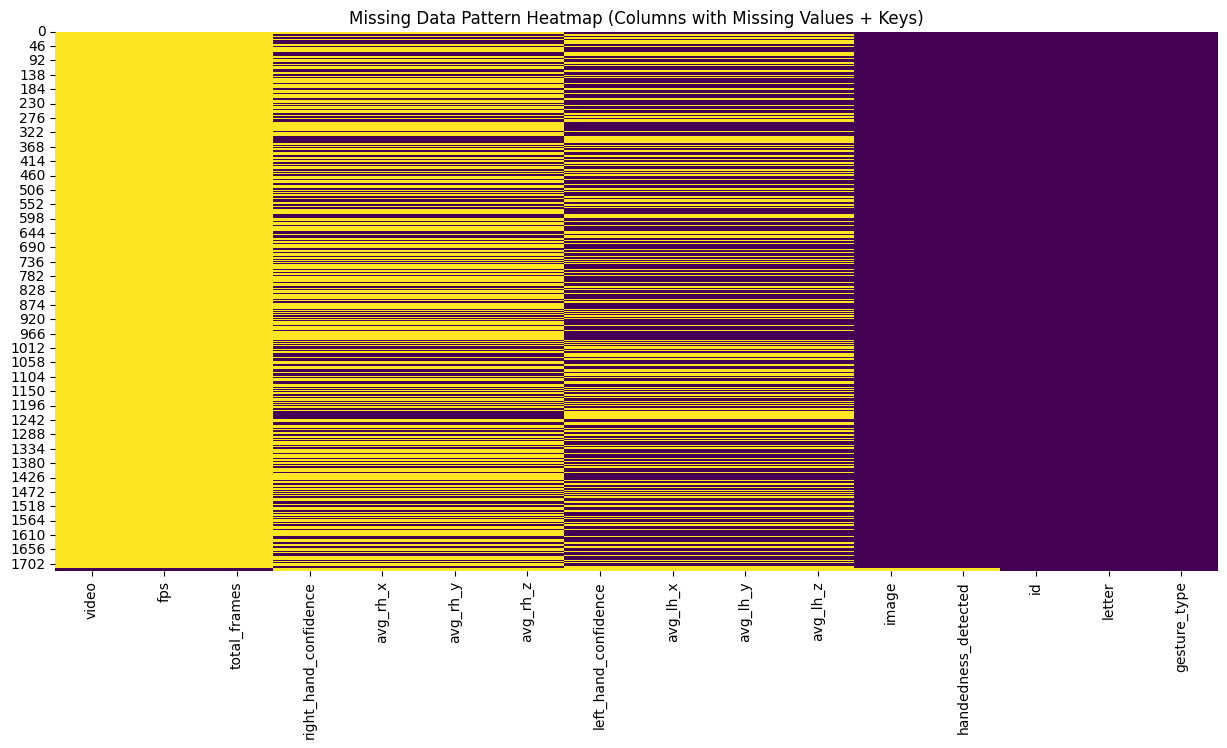


--- Rows with Missing image ---
| id              | image   | video               | letter   | gesture_type   | handedness_detected   | hand_count   | num_rh_landmarks   | num_lh_landmarks   |
|:----------------|:--------|:--------------------|:---------|:---------------|:----------------------|:-------------|:-------------------|:-------------------|
| J_vid_0170423e  |         | J_vid_0170423e.mp4  | J        | dynamic        |                       | 43           | 0                  | 0                  |
| K_vid_a4bdc351  |         | K_vid_a4bdc351.mp4  | K        | dynamic        |                       | 48           | 0                  | 0                  |
| LL_vid_559bdb1b |         | LL_vid_559bdb1b.mp4 | LL       | dynamic        |                       | 100          | 0                  | 0                  |
| Q_vid_9b4f7e50  |         | Q_vid_9b4f7e50.mp4  | Q        | dynamic        |                       | 42           | 0                  | 0                  |
|

In [122]:
print("\n--- Missing Value Analysis ---")
missing_values = gestures_df.isnull().sum()
missing_percent = (missing_values / len(gestures_df)) * 100
missing_info = pd.DataFrame({'Missing Count': missing_values, 'Missing Percentage': missing_percent})

# Filter to show only columns with missing values
missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

print(missing_info.to_markdown(numalign="left", stralign="left"))

# Visualize missing data patterns (using seaborn heatmap)
# Select columns with some missing data + a few key identifiers/targets
cols_for_missing_heatmap = missing_info.index.tolist() + ['id', 'letter', 'gesture_type']
# Limit number of columns for readability if too many have missing data
if len(cols_for_missing_heatmap) > 20:
    cols_for_missing_heatmap = missing_info.head(15).index.tolist() + ['id', 'letter', 'gesture_type']

plt.figure(figsize=(15, 7))
sns.heatmap(gestures_df[cols_for_missing_heatmap].isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Pattern Heatmap (Columns with Missing Values + Keys)')
plt.show()

# Investigate rows with missing image/handedness_detected (small number)
print("\n--- Rows with Missing image ---")
missing_image_rows = gestures_df[gestures_df['image'].isnull()]
if not missing_image_rows.empty:
    # Select key columns for concise display
    display_cols = ['id', 'image', 'video', 'letter', 'gesture_type', 'handedness_detected', 'hand_count', 'num_rh_landmarks', 'num_lh_landmarks']
    print(missing_image_rows[display_cols].to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("No rows found with missing 'image'.")

print("\n--- Rows with Missing handedness_detected ---")
missing_handedness_rows = gestures_df[gestures_df['handedness_detected'].isnull()]
if not missing_handedness_rows.empty:
    display_cols = ['id', 'image', 'video', 'letter', 'gesture_type', 'handedness_detected', 'hand_count', 'num_rh_landmarks', 'num_lh_landmarks']
    print(missing_handedness_rows[display_cols].to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("No rows found with missing 'handedness_detected'.")

# Categorical Variable Frequencies

In [123]:
# Define potential categorical columns (include hand_count for value counts)
# Exclude high cardinality like 'id', 'image', 'source_file' for now
categorical_columns = ['letter', 'gesture_type', 'handedness_detected', 'hand_count', 'rh_present', 'lh_present']

print("\n--- Categorical Variable Frequencies ---")
for col in categorical_columns:
    # Check if column exists before processing
    if col in gestures_df.columns:
        print(f"\nValue Counts for {col}:")
        # Get value counts
        counts = gestures_df[col].value_counts(dropna=False) # Include NaNs in counts if present
        # Convert to DataFrame for better markdown formatting
        counts_df = pd.DataFrame({col: counts.index, 'Count': counts.values})
        # Attempt to sort by index if possible, otherwise sort by count
        try:
            counts_df = counts_df.sort_values(by=col)
        except TypeError:
            counts_df = counts_df.sort_values(by='Count', ascending=False)
        print(counts_df.to_markdown(index=False, numalign="left", stralign="left"))
    else:
        print(f"\nColumn '{col}' not found in DataFrame.")


--- Categorical Variable Frequencies ---

Value Counts for letter:
| letter   | Count   |
|:---------|:--------|
| A        | 147     |
| B        | 106     |
| C        | 75      |
| D        | 62      |
| E        | 27      |
| F        | 78      |
| G        | 26      |
| H        | 28      |
| I        | 25      |
| J        | 25      |
| K        | 100     |
| L        | 90      |
| LL       | 7       |
| M        | 20      |
| N        | 120     |
| O        | 32      |
| P        | 91      |
| Q        | 76      |
| R        | 31      |
| RR       | 16      |
| S        | 223     |
| T        | 125     |
| U        | 30      |
| V        | 31      |
| W        | 29      |
| X        | 24      |
| Y        | 51      |
| Z        | 29      |

Value Counts for gesture_type:
| gesture_type   | Count   |
|:---------------|:--------|
| dynamic        | 277     |
| static         | 1447    |

Value Counts for handedness_detected:
| handedness_detected   | Count   |
|:-----------------

# Outlier Investigation (hand_count)

In [124]:
print("\n--- Outlier Investigation (hand_count) ---")
print("Value Counts for hand_count:")
print(gestures_df['hand_count'].value_counts().sort_index().to_markdown(numalign="left", stralign="left"))

print("\nRows with unusual hand_count (e.g., > 2):")
unusual_hand_count_rows = gestures_df[gestures_df['hand_count'] > 2]
if not unusual_hand_count_rows.empty:
    display_cols = ['id', 'image', 'video', 'letter', 'gesture_type', 'handedness_detected', 'hand_count', 'num_rh_landmarks', 'num_lh_landmarks']
    print(unusual_hand_count_rows[display_cols].to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("No rows found with hand_count > 2.")

# Check if missing image/handedness rows overlap with high hand_count rows
if not missing_image_rows.empty and not unusual_hand_count_rows.empty:
    overlap = pd.merge(missing_image_rows, unusual_hand_count_rows, on='id', how='inner')
    print(f"\nNumber of rows with BOTH missing image/handedness AND unusual hand_count: {len(overlap)}")
else:
    print("\nNo overlap check needed as one set of problematic rows is empty.")


--- Outlier Investigation (hand_count) ---
Value Counts for hand_count:
| hand_count   | count   |
|:-------------|:--------|
| 1            | 1663    |
| 2            | 53      |
| 19           | 1       |
| 42           | 1       |
| 43           | 1       |
| 48           | 1       |
| 64           | 1       |
| 99           | 1       |
| 100          | 2       |

Rows with unusual hand_count (e.g., > 2):
| id              | image   | video               | letter   | gesture_type   | handedness_detected   | hand_count   | num_rh_landmarks   | num_lh_landmarks   |
|:----------------|:--------|:--------------------|:---------|:---------------|:----------------------|:-------------|:-------------------|:-------------------|
| J_vid_0170423e  |         | J_vid_0170423e.mp4  | J        | dynamic        |                       | 43           | 0                  | 0                  |
| K_vid_a4bdc351  |         | K_vid_a4bdc351.mp4  | K        | dynamic        |                       | 

# Visualize Letter Distribution (Class Imbalance Check)

C:\Users\code_\AppData\Local\Temp\ipykernel_28248\507372944.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=gestures_df, x='letter', order=letter_order, palette='viridis')


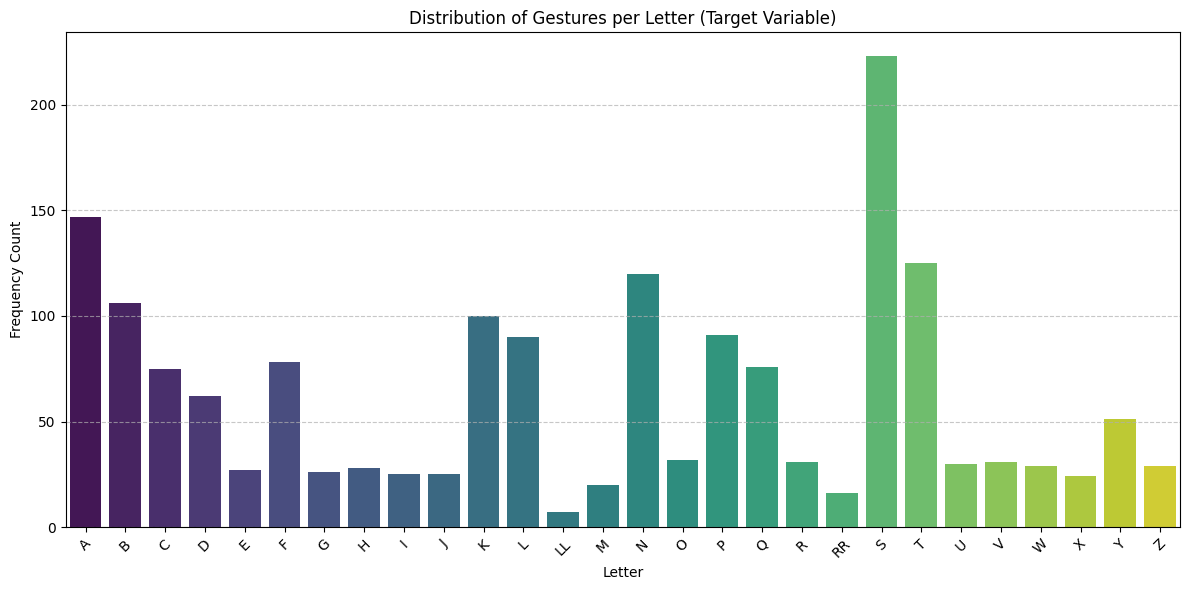

In [125]:
plt.figure(figsize=(12, 6))
# Ensure 'letter' column exists
if 'letter' in gestures_df.columns:
    # Order bars by letter
    letter_order = gestures_df['letter'].value_counts().sort_index().index
    sns.countplot(data=gestures_df, x='letter', order=letter_order, palette='viridis')
    plt.title('Distribution of Gestures per Letter (Target Variable)')
    plt.xlabel('Letter')
    plt.ylabel('Frequency Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\n'letter' column not found, cannot visualize distribution.")

In [126]:
# Create a copy to work on
df_clean = gestures_df.copy()

# --- 1. Drop Problematic Rows ---
# Identify rows to drop (where 'video' is not null, or equivalently, where 'image' is null)
rows_to_drop_indices = df_clean[df_clean['video'].notnull()].index
initial_rows = len(df_clean)
df_clean.drop(rows_to_drop_indices, inplace=True)
rows_dropped = initial_rows - len(df_clean)
print(f"--- Preprocessing: Dropped {rows_dropped} rows (video entries with multiple issues). ---")
print(f"Justification: These {rows_dropped} rows had missing image/handedness, outlier hand counts, and zero landmarks, indicating corrupted data or failed processing.")



--- Preprocessing: Dropped 8 rows (video entries with multiple issues). ---
Justification: These 8 rows had missing image/handedness, outlier hand counts, and zero landmarks, indicating corrupted data or failed processing.


In [127]:
# Drop Columns
columns_to_drop = [
    'id', 'source_file', 'image',  # Identifiers
    'video', 'fps', 'total_frames', # High missingness / Video related
    'image_width', 'image_height', # Constants
    'rh_present', 'lh_present' # Helpers (info redundant with NaNs/counts)
]
# Drop only columns that actually exist in the DataFrame
columns_exist_to_drop = [col for col in columns_to_drop if col in df_clean.columns]
df_clean.drop(columns=columns_exist_to_drop, inplace=True)
print(f"\n--- Preprocessing: Dropped columns: {', '.join(columns_exist_to_drop)}. ---")
print("Justification: Removed identifiers, constant columns, columns with excessive missing values, and redundant helper columns.")

# Clean handedness_detected
print("\n--- Preprocessing: Cleaning 'handedness_detected' column. ---")
# Check unique values before cleaning (should not contain NaN after dropping rows)
print("Original unique values:", df_clean['handedness_detected'].unique())

def clean_handedness(value):
    if pd.isnull(value) or not isinstance(value, str) or value.strip() == '':
         # This case shouldn't happen after dropping rows, but handle defensively
        return 'unknown'
    # Sort parts for consistency ('left, right' vs 'right, left')
    parts = sorted([p.strip() for p in value.split(',')])
    cleaned = ', '.join(parts)

    if cleaned == 'left, left':
        return 'left'
    elif cleaned == 'right, right':
        return 'right'
    elif cleaned == 'left, right':
        return 'both'
    elif cleaned == 'left' or cleaned == 'right':
        return cleaned
    else:
        # Log unexpected values if any
        print(f"Unexpected handedness value found: {value} -> mapped to 'unknown'")
        return 'unknown'


--- Preprocessing: Dropped columns: id, source_file, image, video, fps, total_frames, image_width, image_height, rh_present, lh_present. ---
Justification: Removed identifiers, constant columns, columns with excessive missing values, and redundant helper columns.

--- Preprocessing: Cleaning 'handedness_detected' column. ---
Original unique values: ['right' 'left' 'left, right' 'left, left' 'right, right']


In [128]:
df_clean['handedness_detected'] = df_clean['handedness_detected'].apply(clean_handedness)
print("Cleaned unique values:", df_clean['handedness_detected'].unique())
print("Value counts after cleaning:")
# Convert to DataFrame for better markdown formatting
handedness_counts_df = pd.DataFrame(df_clean['handedness_detected'].value_counts())
handedness_counts_df.columns = ['Count']
print(handedness_counts_df.to_markdown(numalign="left", stralign="left"))

# --- 4. Impute Hand Confidence ---
df_clean['right_hand_confidence'].fillna(0, inplace=True)
df_clean['left_hand_confidence'].fillna(0, inplace=True)
print("\n--- Preprocessing: Imputed NaN in hand confidence columns with 0. ---")
print("Justification: NaN indicates the respective hand was not detected; 0 confidence reflects this.")

Cleaned unique values: ['right' 'left' 'both']
Value counts after cleaning:
| handedness_detected   | Count   |
|:----------------------|:--------|
| left                  | 956     |
| right                 | 714     |
| both                  | 46      |

--- Preprocessing: Imputed NaN in hand confidence columns with 0. ---
Justification: NaN indicates the respective hand was not detected; 0 confidence reflects this.


C:\Users\code_\AppData\Local\Temp\ipykernel_28248\2223860530.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['right_hand_confidence'].fillna(0, inplace=True)
C:\Users\code_\AppData\Local\Temp\ipykernel_28248\2223860530.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [129]:
# --- Verification ---
print("\n--- Cleaned DataFrame Info ---")
df_clean.info()

print("\n--- Missing Values After Preprocessing ---")
missing_after = df_clean.isnull().sum()
missing_after = missing_after[missing_after > 0]
if missing_after.empty:
    print("No unexpected missing values remain (NaNs in avg landmark coords are expected).")
else:
    print("Remaining unexpected missing values:")
    print(missing_after.to_markdown(numalign="left", stralign="left"))
    # Check the specific columns if needed
    if 'avg_rh_x' in missing_after.index or 'avg_lh_x' in missing_after.index:
        print("\nNote: NaNs in 'avg_rh_x/y/z' and 'avg_lh_x/y/z' are expected when the corresponding hand was not detected.")
        # Remove expected NaNs from the check
        missing_after = missing_after.drop([col for col in ['avg_rh_x', 'avg_rh_y', 'avg_rh_z', 'avg_lh_x', 'avg_lh_y', 'avg_lh_z'] if col in missing_after.index])
        if missing_after.empty:
             print("All remaining NaNs are in expected landmark average columns.")
        else:
             print("Unexpected NaNs remain in:")
             print(missing_after.to_markdown(numalign="left", stralign="left"))



--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716 entries, 0 to 1715
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   letter                 1716 non-null   object             
 1   gesture_type           1716 non-null   object             
 2   timestamp              1716 non-null   datetime64[ns, UTC]
 3   hand_count             1716 non-null   int64              
 4   handedness_detected    1716 non-null   object             
 5   right_hand_confidence  1716 non-null   float64            
 6   left_hand_confidence   1716 non-null   float64            
 7   num_rh_landmarks       1716 non-null   Int64              
 8   avg_rh_x               760 non-null    float64            
 9   avg_rh_y               760 non-null    float64            
 10  avg_rh_z               760 non-null    float64            
 11  num_lh_landmarks       1


--- Univariate Analysis: Categorical Variables (Cleaned Data) ---


C:\Users\code_\AppData\Local\Temp\ipykernel_28248\275825512.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x=col, palette='viridis', order=order)
C:\Users\code_\AppData\Local\Temp\ipykernel_28248\275825512.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x=col, palette='viridis', order=order)
C:\Users\code_\AppData\Local\Temp\ipykernel_28248\275825512.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x=col, palette='viridis', order=order)
C:\Users\code_\AppData\Local\Temp\ipyker

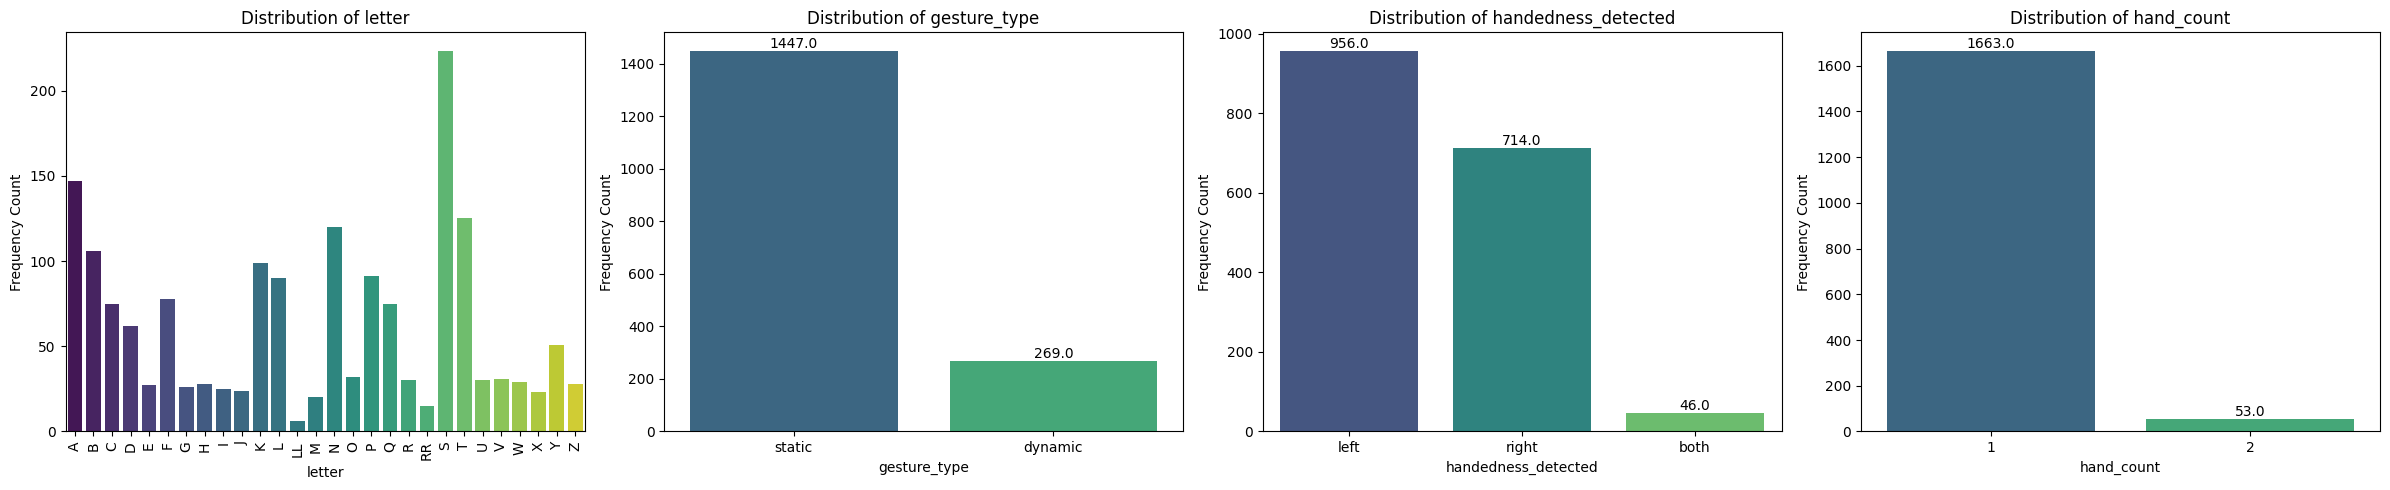

In [130]:
# Define numerical columns for visualization (excluding counts/constants)
numerical_cols_viz = [
    'right_hand_confidence', 'left_hand_confidence',
    'avg_rh_x', 'avg_rh_y', 'avg_rh_z',
    'avg_lh_x', 'avg_lh_y', 'avg_lh_z'
]
# Define categorical columns for visualization
categorical_cols_viz = ['letter', 'gesture_type', 'handedness_detected', 'hand_count']

# --- Categorical Variable Plots ---
print("\n--- Univariate Analysis: Categorical Variables (Cleaned Data) ---")
num_cat_cols = len(categorical_cols_viz)
plt.figure(figsize=(6 * num_cat_cols, 5)) # Adjust figsize based on number of columns

for i, col in enumerate(categorical_cols_viz, start=1):
    plt.subplot(1, num_cat_cols, i)
    # For 'letter', rotate ticks and maybe limit number shown if too many?
    if col == 'letter':
        # Order by letter
        order = sorted(df_clean[col].unique())
        sns.countplot(data=df_clean, x=col, palette='viridis', order=order)
        plt.xticks(rotation=90) # Rotate labels for readability
    else:
         # Order by frequency for others
         order = df_clean[col].value_counts().index
         sns.countplot(data=df_clean, x=col, palette='viridis', order=order)
         # Add counts on top of bars for low-cardinality columns
         if df_clean[col].nunique() < 10:
              ax = plt.gca()
              for p in ax.patches:
                  ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                              textcoords='offset points')

    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency Count')


plt.tight_layout()
plt.show()

# Numerical Variable Plots: Histograms


--- Univariate Analysis: Numerical Variables - Histograms (Cleaned Data) ---
Skewness for right_hand_confidence: 0.24
Skewness for left_hand_confidence: -0.32
Skewness for avg_rh_x: 0.12
Skewness for avg_rh_y: 1.12
Skewness for avg_rh_z: -1.16
Skewness for avg_lh_x: -0.24
Skewness for avg_lh_y: 0.63
Skewness for avg_lh_z: -1.89


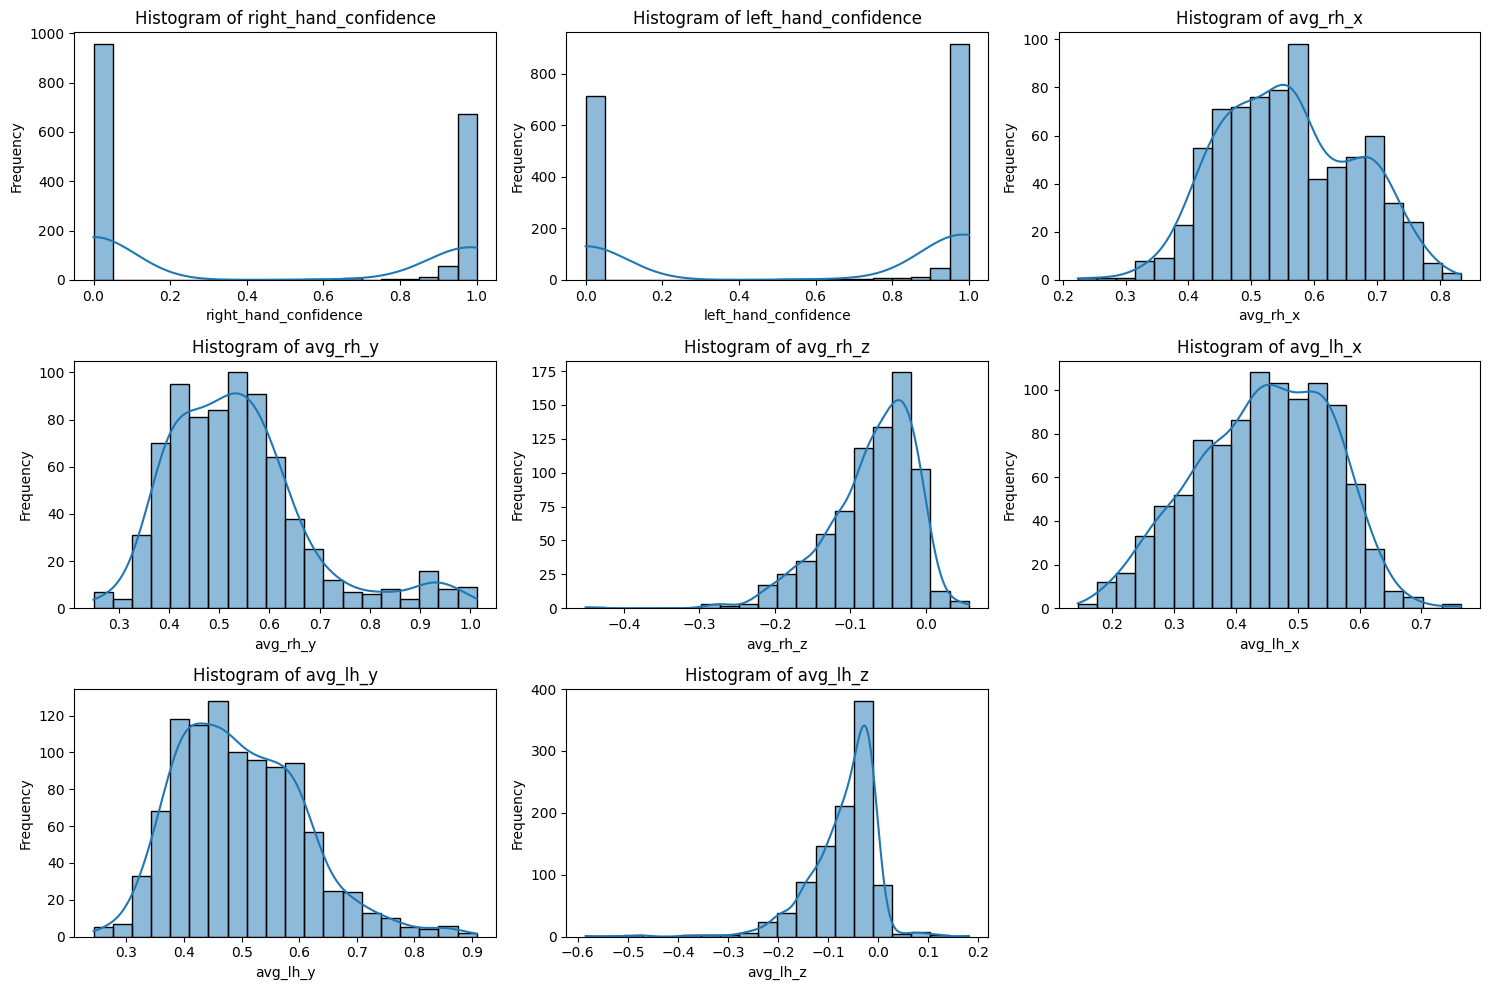


--- Univariate Analysis: Numerical Variables - Box Plots (Cleaned Data) ---


C:\Users\code_\AppData\Local\Temp\ipykernel_28248\1972338686.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x='Variable', y='Value', palette='viridis')


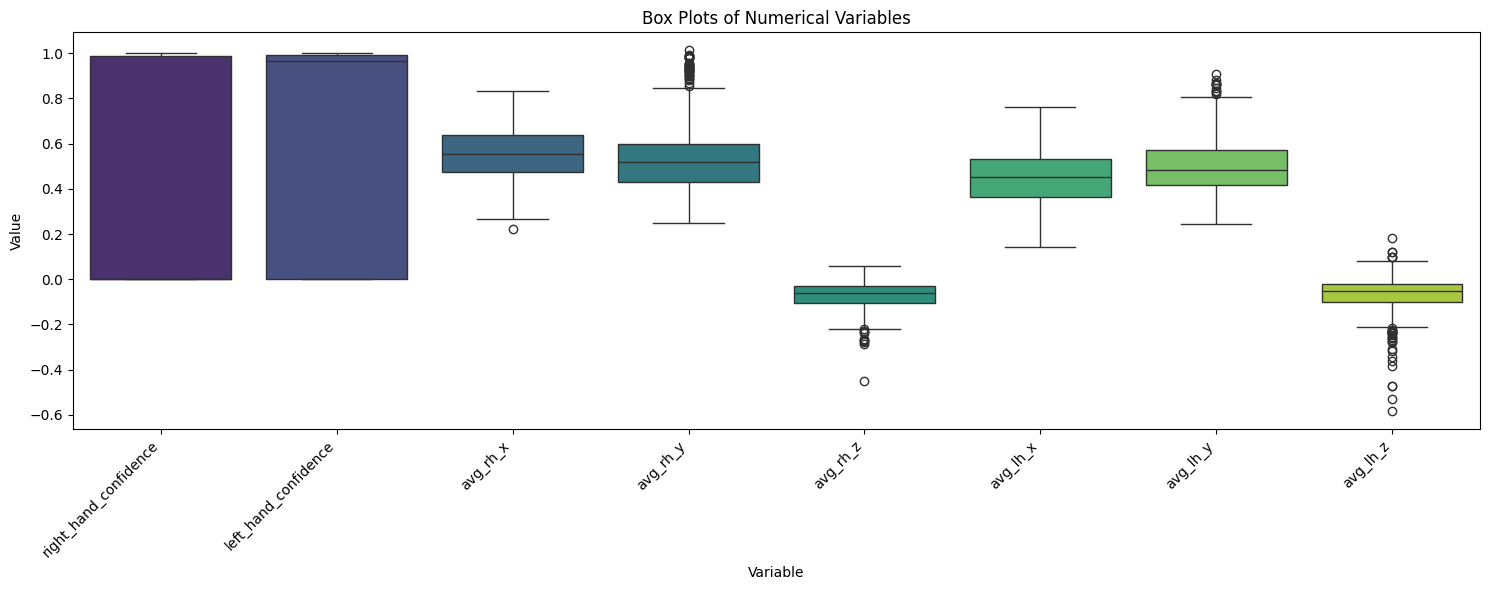

In [131]:
print("\n--- Univariate Analysis: Numerical Variables - Histograms (Cleaned Data) ---")
# Select only columns that exist in df_clean
numerical_cols_viz_exist = [col for col in numerical_cols_viz if col in df_clean.columns]

plt.figure(figsize=(15, 10)) # Adjust size as needed
num_numerical_cols = len(numerical_cols_viz_exist)
rows = (num_numerical_cols + 2) // 3 # Adjust grid layout

for i, col in enumerate(numerical_cols_viz_exist, start=1):
    plt.subplot(rows, 3, i)
    # Plot histogram, handle potential NaNs by dropping them for plotting
    sns.histplot(df_clean[col].dropna(), kde=True, bins=20)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    # Calculate skewness (on non-NaN data)
    try:
      skewness = df_clean[col].dropna().skew()
      print(f"Skewness for {col}: {skewness:.2f}")
    except:
      print(f"Could not calculate skewness for {col}")


plt.tight_layout()
plt.show()

# --- Numerical Variable Plots: Box Plots ---
print("\n--- Univariate Analysis: Numerical Variables - Box Plots (Cleaned Data) ---")
plt.figure(figsize=(15, 6))
# Melt the dataframe to plot all numerical variables on one plot with shared y-axis if needed
# Or plot individually if scales differ significantly
# Let's try melting for comparison, dropping NaNs
df_melt = df_clean[numerical_cols_viz_exist].melt(var_name='Variable', value_name='Value')
sns.boxplot(data=df_melt, x='Variable', y='Value', palette='viridis')
plt.title('Box Plots of Numerical Variables')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [132]:
# Define numerical columns for correlation (same as used for visualization)
numerical_cols_corr = [
    'right_hand_confidence', 'left_hand_confidence',
    'avg_rh_x', 'avg_rh_y', 'avg_rh_z',
    'avg_lh_x', 'avg_lh_y', 'avg_lh_z'
]
# Filter for columns that actually exist in df_clean
numerical_cols_corr_exist = [col for col in numerical_cols_corr if col in df_clean.columns]


# Correlation Analysis (Numerical Variables)


--- Bi/Multivariate Analysis: Correlation Matrix ---


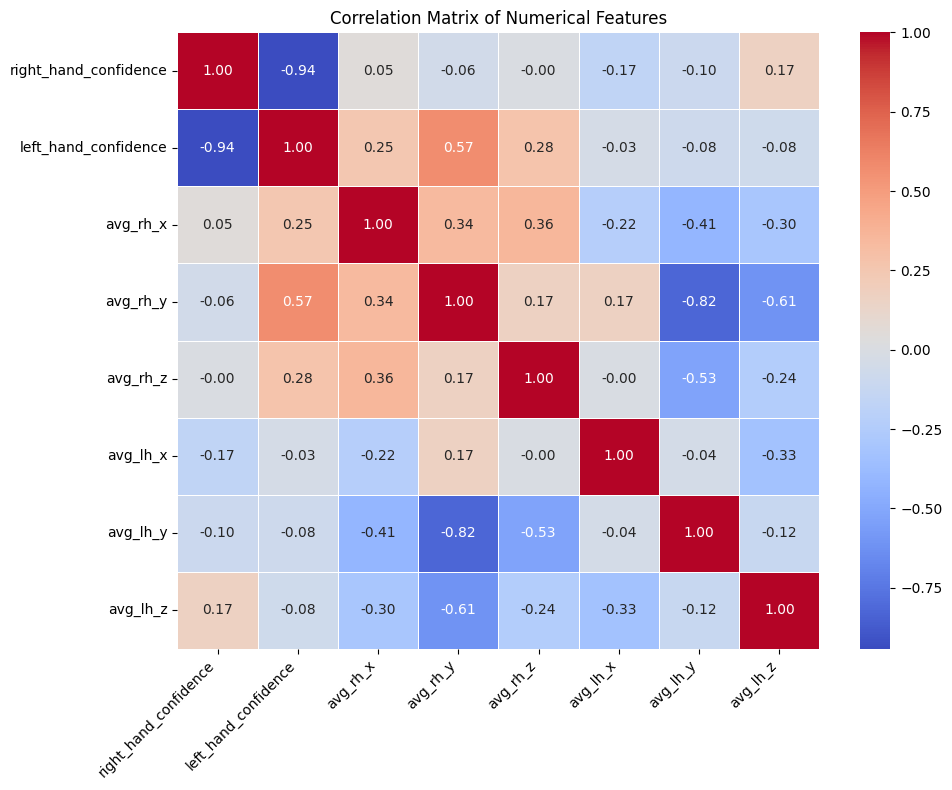


Correlation Matrix Values:
|                       | right_hand_confidence   | left_hand_confidence   | avg_rh_x   | avg_rh_y   | avg_rh_z     | avg_lh_x    | avg_lh_y   | avg_lh_z   |
|:----------------------|:------------------------|:-----------------------|:-----------|:-----------|:-------------|:------------|:-----------|:-----------|
| right_hand_confidence | 1                       | -0.942238              | 0.0470938  | -0.0583062 | -0.000791794 | -0.166475   | -0.0962635 | 0.166234   |
| left_hand_confidence  | -0.942238               | 1                      | 0.254683   | 0.572451   | 0.279195     | -0.0323963  | -0.0843281 | -0.0761233 |
| avg_rh_x              | 0.0470938               | 0.254683               | 1          | 0.339135   | 0.357079     | -0.221888   | -0.412459  | -0.3013    |
| avg_rh_y              | -0.0583062              | 0.572451               | 0.339135   | 1          | 0.172943     | 0.171457    | -0.823181  | -0.612025  |
| avg_rh_z              

In [133]:

print("\n--- Bi/Multivariate Analysis: Correlation Matrix ---")
# Calculate correlation matrix (default method='pearson', handles NaNs by pairwise deletion)
correlation_matrix = df_clean[numerical_cols_corr_exist].corr()

plt.figure(figsize=(10, 8)) # Adjusted size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix Values:")
print(correlation_matrix.to_markdown(numalign="left", stralign="left"))
print("\nNote: Correlations involving avg_rh_* and avg_lh_* are calculated pairwise, only using rows where both variables are non-NaN.")

# Categorical vs. Numerical


--- Bi/Multivariate Analysis: Categorical vs. Numerical ---


C:\Users\code_\AppData\Local\Temp\ipykernel_28248\2499860608.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean.dropna(subset=['avg_lh_x']), x='letter', y='avg_lh_x', order=sorted(df_clean['letter'].unique()), palette='viridis')


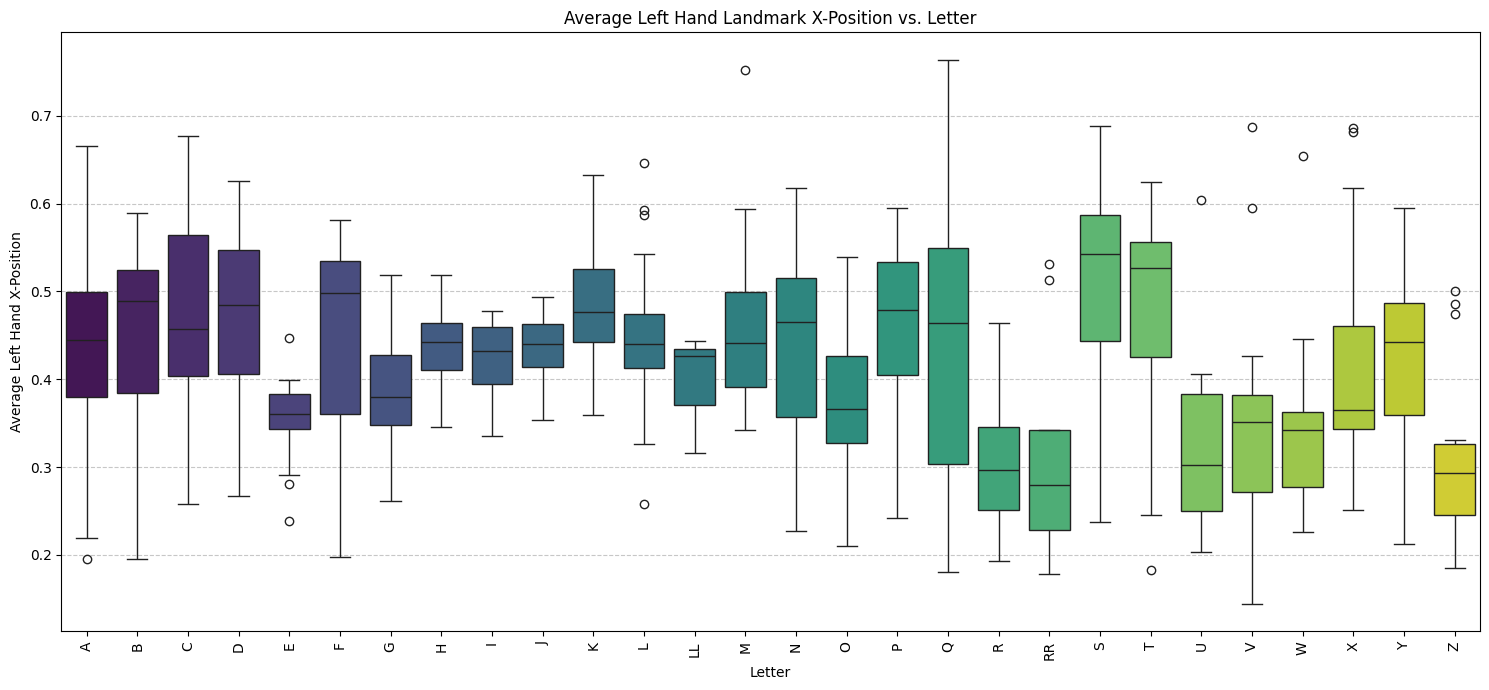

C:\Users\code_\AppData\Local\Temp\ipykernel_28248\2499860608.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean.dropna(subset=['avg_rh_y']), x='letter', y='avg_rh_y', order=sorted(df_clean['letter'].unique()), palette='viridis')


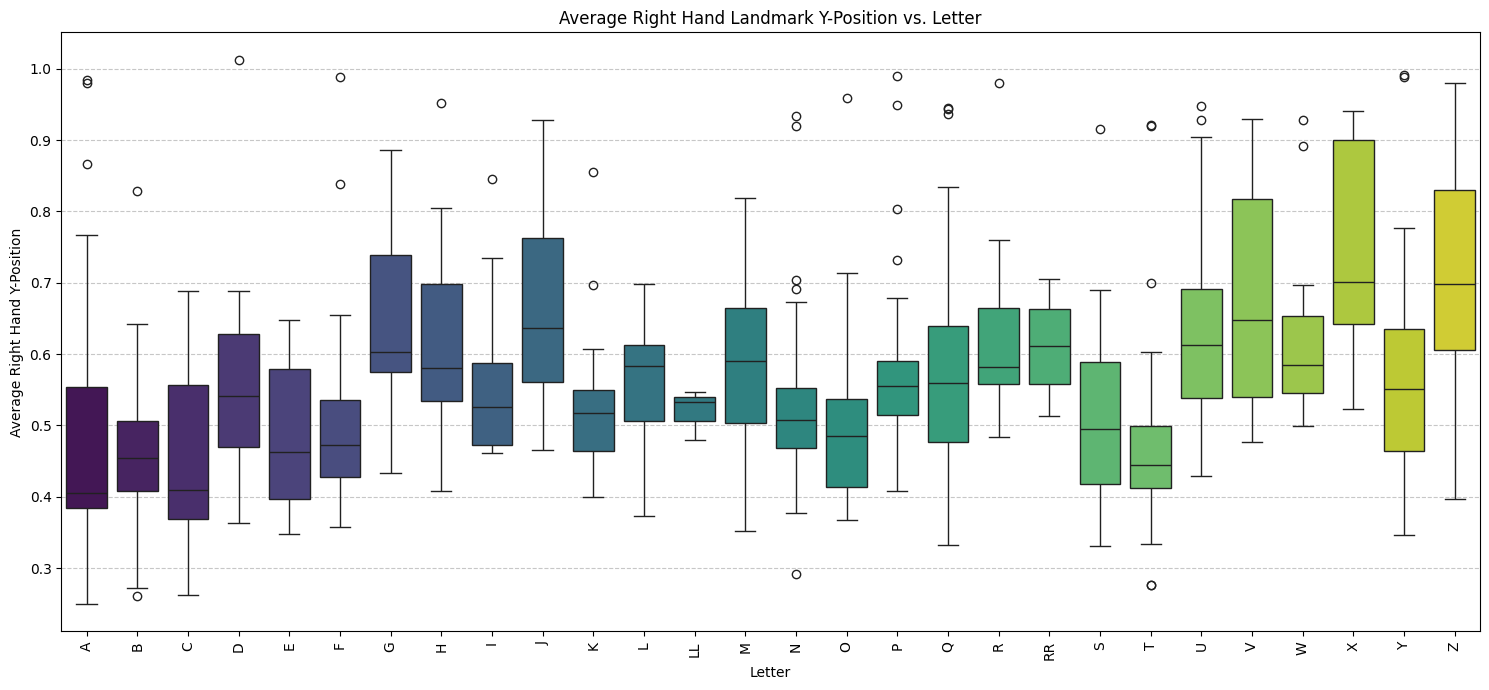

C:\Users\code_\AppData\Local\Temp\ipykernel_28248\2499860608.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], data=df_clean, x='handedness_detected', y='left_hand_confidence', palette='viridis')
C:\Users\code_\AppData\Local\Temp\ipykernel_28248\2499860608.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df_clean, x='handedness_detected', y='right_hand_confidence', palette='viridis')


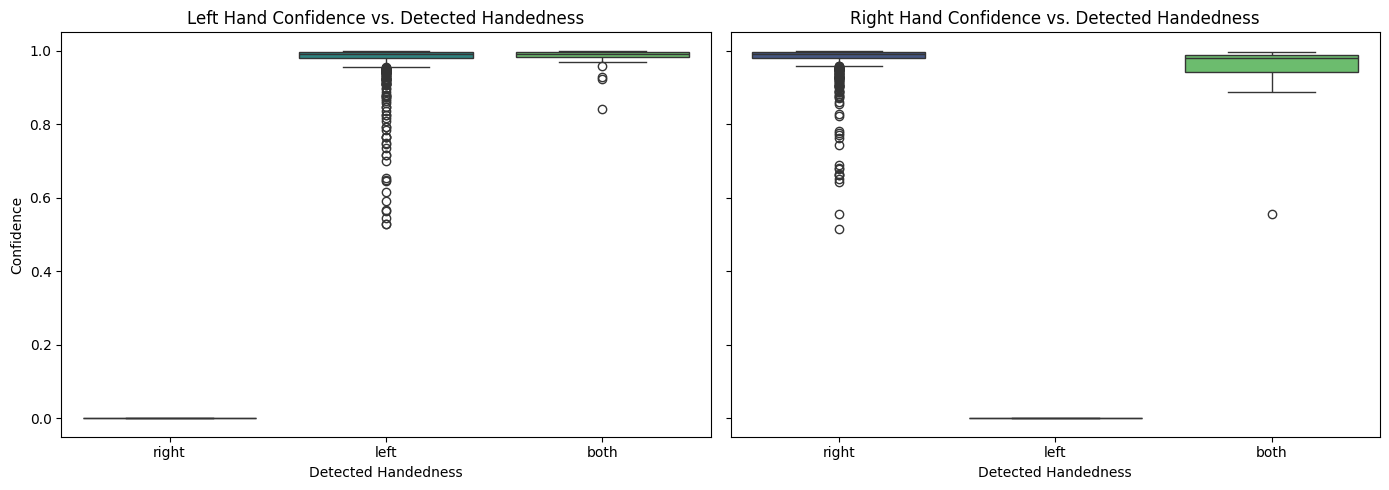

In [134]:

print("\n--- Bi/Multivariate Analysis: Categorical vs. Numerical ---")

# Example 1: Average Left Hand X position vs. Letter
plt.figure(figsize=(15, 7))
# Filter out NaN values for this plot for clarity
sns.boxplot(data=df_clean.dropna(subset=['avg_lh_x']), x='letter', y='avg_lh_x', order=sorted(df_clean['letter'].unique()), palette='viridis')
plt.title('Average Left Hand Landmark X-Position vs. Letter')
plt.xlabel('Letter')
plt.ylabel('Average Left Hand X-Position')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Example 2: Average Right Hand Y position vs. Letter
plt.figure(figsize=(15, 7))
# Filter out NaN values for this plot
sns.boxplot(data=df_clean.dropna(subset=['avg_rh_y']), x='letter', y='avg_rh_y', order=sorted(df_clean['letter'].unique()), palette='viridis')
plt.title('Average Right Hand Landmark Y-Position vs. Letter')
plt.xlabel('Letter')
plt.ylabel('Average Right Hand Y-Position')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Example 3: Hand Confidence vs. Detected Handedness
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
sns.boxplot(ax=axes[0], data=df_clean, x='handedness_detected', y='left_hand_confidence', palette='viridis')
axes[0].set_title('Left Hand Confidence vs. Detected Handedness')
axes[0].set_xlabel('Detected Handedness')
axes[0].set_ylabel('Confidence')

sns.boxplot(ax=axes[1], data=df_clean, x='handedness_detected', y='right_hand_confidence', palette='viridis')
axes[1].set_title('Right Hand Confidence vs. Detected Handedness')
axes[1].set_xlabel('Detected Handedness')
axes[1].set_ylabel('Confidence')

plt.tight_layout()
plt.show()

# Categorical vs. Categorical


--- Bi/Multivariate Analysis: Categorical vs. Categorical ---

Crosstab: Handedness vs. Gesture Type
| handedness_detected   | dynamic   | static   |
|:----------------------|:----------|:---------|
| both                  | 9         | 37       |
| left                  | 148       | 808      |
| right                 | 112       | 602      |


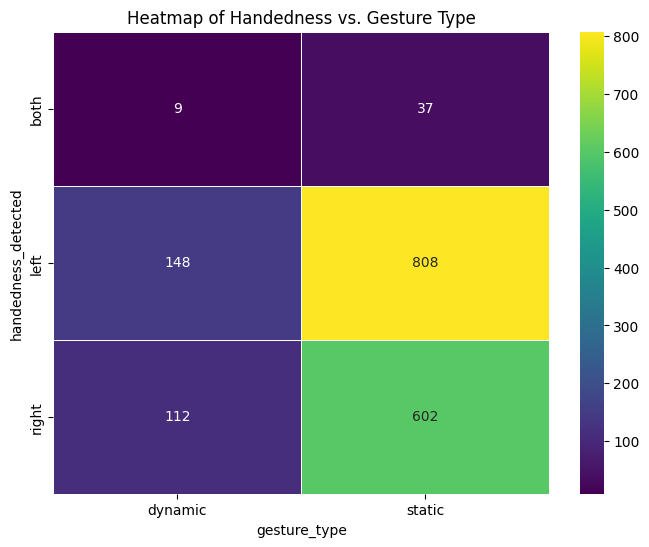

In [135]:

print("\n--- Bi/Multivariate Analysis: Categorical vs. Categorical ---")
# Example: Handedness vs Gesture Type
ctab = pd.crosstab(df_clean['handedness_detected'], df_clean['gesture_type'])
print("\nCrosstab: Handedness vs. Gesture Type")
print(ctab.to_markdown(numalign="left", stralign="left"))

plt.figure(figsize=(8, 6))
sns.heatmap(ctab, annot=True, fmt='d', cmap='viridis', linewidths=.5)
plt.title('Heatmap of Handedness vs. Gesture Type')
plt.show()



# Temporal Analysis


--- Bi/Multivariate Analysis: Temporal Analysis ---


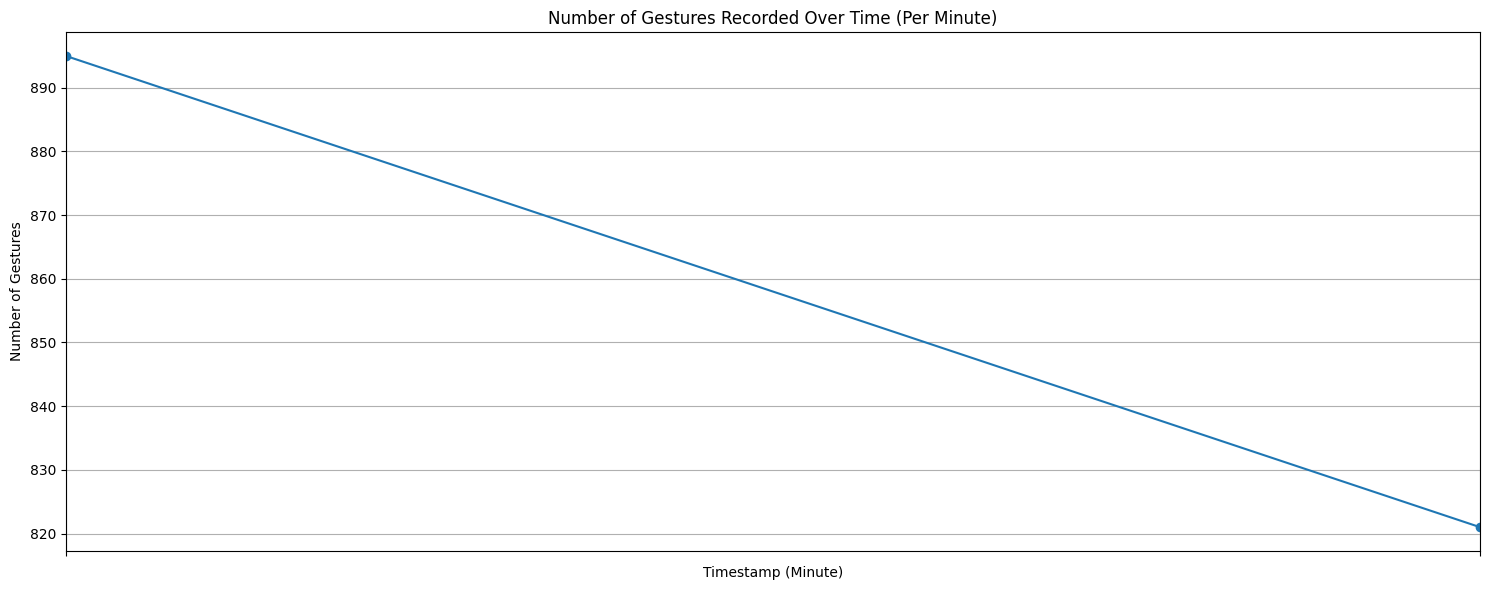

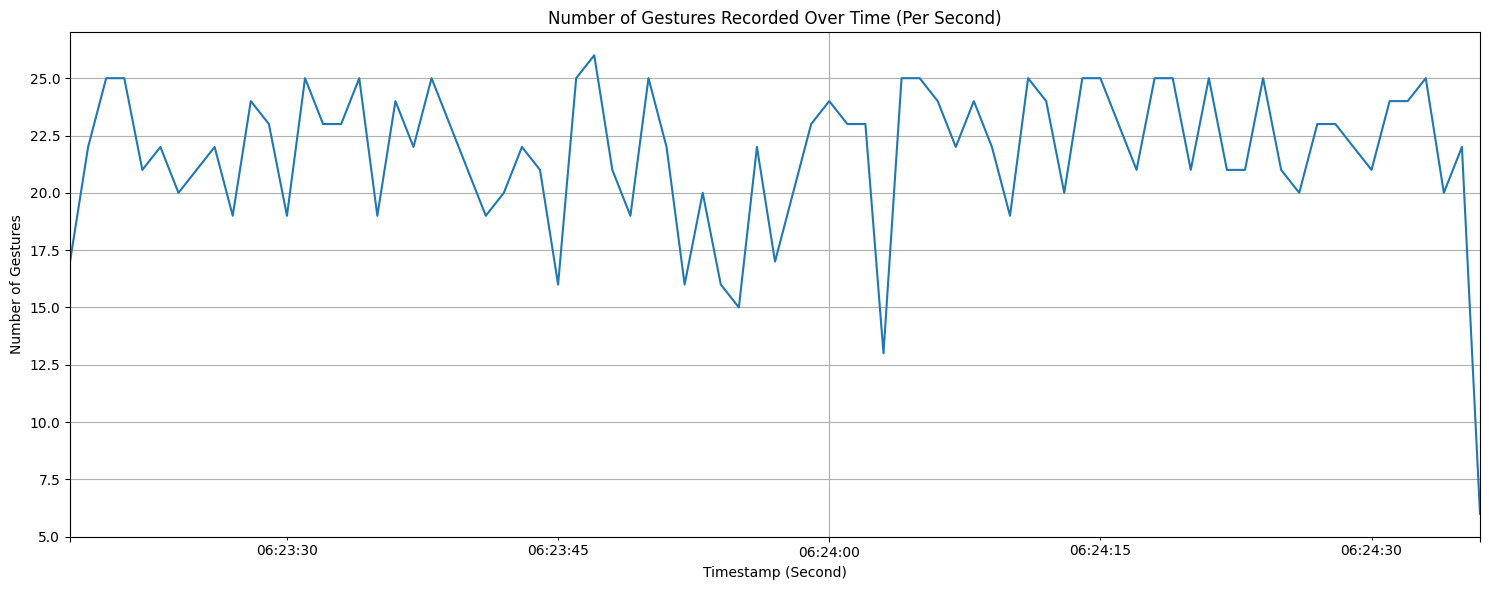

In [136]:
print("\n--- Bi/Multivariate Analysis: Temporal Analysis ---")
# Ensure timestamp is sorted for plotting
df_clean_sorted = df_clean.sort_values('timestamp')

# Plot gesture counts over time (e.g., per minute or hour)
plt.figure(figsize=(15, 6))
# Resample by minute to see trends if data spans short period
df_clean_sorted.set_index('timestamp')['letter'].resample('min').count().plot(marker='o', linestyle='-')
plt.title('Number of Gestures Recorded Over Time (Per Minute)')
plt.xlabel('Timestamp (Minute)')
plt.ylabel('Number of Gestures')
plt.grid(True)
plt.tight_layout()
plt.show()

# Resample by second to see capture frequency
plt.figure(figsize=(15, 6))
df_clean_sorted.set_index('timestamp')['letter'].resample('s').count().plot()
plt.title('Number of Gestures Recorded Over Time (Per Second)')
plt.xlabel('Timestamp (Second)')
plt.ylabel('Number of Gestures')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. Conclusions

This Exploratory Data Analysis was conducted on the `gestures.json` dataset, incorporating updated processing steps for the landmark data structure. We reamind to everyone that the script that generates the Json file is still in progress so the distribution of the data could change in the future. Here's a summary addressing the key EDA questions:

---

## Data Structure

- The dataset initially contained **1,724 entries**. After processing and cleaning, **1,716 entries** (static images) remained.
- Columns include:
  - **Gesture information**: `letter`, `gesture_type`
  - **Detection details**: `hand_count`, `handedness_detected`, `right_hand_confidence`, `left_hand_confidence`
  - **Extracted landmark features**: `num_rh/lh_landmarks`, `avg_rh/lh_x/y/z`
  - **Timestamp**
- Descriptive statistics showed:
  - Expected confidence values in **[0, 1]**
  - Landmark coordinates mostly in **[0, 1]** for x/y
  - Landmark count values as **0 or 21** after cleaning

---

## Missing Values

- **High missingness** in `video`, `fps`, `total_frames` (>99%)
- `image` and `handedness_detected`: **8 missing values**
- NaNs in confidence and landmarks matched undetected hands

**Pattern & Handling**:
- The 8 rows missing `image`/`handedness` were identified as problematic **video entries**
- Actions taken:
  - Dropped the 8 problematic rows
  - Dropped high-missingness and redundant identifier columns
  - Imputed confidence NaNs with **0**
  - Retained landmark NaNs to signify **hand absence**

---

## Outliers

- Found extreme outliers in `hand_count` (up to 100) within problematic video rows
- These were removed during cleaning
- **Box plots** showed potential outliers in landmark coordinates, retained as they may reflect valid variations

---

## Cardinality

- `letter`: **28 unique values**
- `gesture_type`: **2 unique values**
- `handedness_detected`: **3 unique values** (`left`, `right`, `both`)

No high cardinality issues requiring special preprocessing were found.

---

## Skewed Distributions & Transformations

- **Skewness** observed:
  - `avg_rh_y`: 1.12
  - `avg_rh_z`: -1.16
  - `avg_lh_z`: -1.89
  - `avg_lh_y`: 0.63 (moderate)

These features may require **log or Box-Cox transformations** in downstream modeling.

---

## Temporal Trends

- `timestamp` indicates data collection over ~13 minutes on **2025-05-05**
- Activity occurred in bursts (likely grouped by letter)
- No long-term trends

---

## Correlation (Dependent vs Independent)

- **Dependent variable**: `letter`
- **Strong negative correlation** between `left_hand_confidence` and `right_hand_confidence`: **-0.94**
- Moderate correlation:
  - `avg_rh_y` vs `avg_lh_y`: **-0.82** (when both hands are present)
- **Box plots**:
  - Show clear separability of letters using average landmark positions

---

## Data Distribution Across Categories

- Most frequent letter: **'S'**
- Most common `gesture_type`: **'static'**
- Most common `handedness_detected`: **'left'**
- Majority `hand_count`: **1**
- Crosstab shows **left-handed static gestures** are the most prevalent

---

## Image Normalization

- `avg_rh/lh_x/y` mostly in **[0, 1]**, consistent with **MediaPipe normalization**
- `avg_rh/lh_z` reflects depth, on a different scale
- Further normalization may benefit specific models but was not applied in this EDA

---

## Class Imbalance

- Significant imbalance:
  - 'S': **223 instances**
  - 'LL': **7 instances**
  - 'M': **20 instances**
- This will need correction during modeling using **resampling** or **class weighting**

---

## Summary

The EDA on the revised dataset:

- Identified and cleaned problematic entries
- Analyzed the distribution and relationships of critical features
- Highlighted:
  - **Class imbalance**
  - **Feature skewness**
  - **Potentially predictive landmark positions**

The dataset is now prepared for model training, with **landmark-based features** showing strong potential for sign language letter classification.
